In [1]:
%cd /home/kong/14_disease_2022/tmp/yolov5/

/home/kong/14_disease_2022/tmp/yolov5


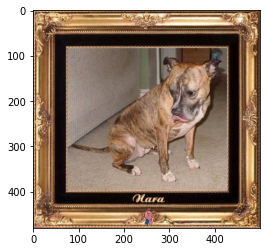

In [2]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pickle
im = cv2.imread("/home/kong/simple_detection_dogcat/dataset/image/dog.98.jpg")
im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
plt.imshow(im)

In [3]:
from fastapi.middleware.cors import CORSMiddleware
from fastapi import FastAPI, File, Body, UploadFile, Request
from typing import Optional
from pydantic import BaseModel
from starlette.responses import JSONResponse
import uvicorn
from uvicorn.config import LOGGING_CONFIG
from PIL import Image, ImageDraw, ImageFont
import io
import matplotlib.pyplot as plt

# import the needed libraries
import argparse
import os
import platform
import shutil
import time
from pathlib import Path

import cv2
import torch
import torch.backends.cudnn as cudnn
import numpy as np
from numpy import random

from models.experimental import attempt_load
from utils.datasets import LoadStreams, LoadImages, letterbox
from utils.general import check_img_size, check_requirements, check_imshow, non_max_suppression, apply_classifier, \
    scale_coords, xyxy2xywh, strip_optimizer, set_logging, increment_path
# from utils.plots import plot_one_box_PIL
from utils.torch_utils import select_device, time_sync

import base64
import json
import requests

In [33]:
class Opt():
    def __init__(self,project="",
                 img_size=640,
                 conf_thres=0.8,
                 iou_thres=0.5,
                 weights="/home/kong/14_disease_2022/tmp/yolov5/runs/train/exp7/weights/best.pt",
                 device='cpu',
                 classes=None,
                 agnostic_nms=False,
                 augment=False):
        self.project = project
        self.weights = weights
        self.img_size = img_size
        self.conf_thres = conf_thres
        self.iou_thres = iou_thres
        self.device = device
        self.classes = classes
        self.agnostic_nms = agnostic_nms
        self.augment = augment
#         self.server_port = server_port
    

In [34]:
opt = Opt()

In [35]:
def plot_one_box_PIL(box, img, color=None, label=None, line_thickness=None):
    # img = Image.fromarray(img)
    draw = ImageDraw.Draw(img)
    line_thickness = line_thickness or max(int(min(img.size) / 200), 2)
#     draw.rectangle(box, width=line_thickness, outline=tuple(color))  # plot
#     draw.rectangle(box, width=line_thickness, outline="red")
    draw.rectangle(box, width=line_thickness, outline=color)
    if label:
        fontsize = max(round(max(img.size) / 40), 12)
        font = ImageFont.truetype("font/arial.ttf", fontsize)
        txt_width, txt_height = font.getsize(label)
#         draw.rectangle([box[0], box[1] - txt_height + 4, box[0] + txt_width, box[1]], fill='red')
        draw.rectangle([box[0], box[1] - txt_height + 4, box[0] + txt_width, box[1]], fill=color)
        draw.text((box[0], box[1] - txt_height + 1), label, font=font)
        draw.text(((box[0], box[1] - txt_height + 1)), label,fill='white', font = font)
    return np.asarray(img)

def draw_image(frame, pred, names, img, colors):
    width, height = frame.size
    newsize = (height, width)

    result = []
    for i, det in enumerate(pred):  # detections per image
        gn = torch.tensor(newsize)[[1, 0, 1, 0]]  # normalization gain whwh
        if det is not None and len(det):
            # Rescale boxes from img_size to im0 size
            det[:, :4] = scale_coords(img.shape[2:], det[:, :4], newsize).round()

            # Write results
            for *xyxy, conf, cls in det:
                score = float('%.8f' % (conf)) *100
                result.append({
                    "class_name": names[int(cls)],
                    "confidence": score,
                    "position": {
                        "xmin": int(xyxy[0]),
                        "ymin": int(xyxy[1]),
                        "xmax": int(xyxy[2]),
                        "ymax": int(xyxy[3])
                    }
                })
                label = f'{names[int(cls)]} {score:.2f}%'
                plot_one_box_PIL(xyxy, frame, label=label, color=colors[int(cls)], line_thickness=5)
    return frame, result
def preprocess_image(frame):

    frame = np.array(frame)

    # Padded resize
    img = letterbox(frame, new_shape=imgsz)[0]
    if len(img.shape) < 3:
        img = np.stack((img,)*3, axis=-1)

    # Convert
    img = img[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to 3x416x416
    img = np.ascontiguousarray(img)
    img = torch.from_numpy(img).to(device)
    img = img.half() if half else img.float()  # uint8 to fp16/32
    img /= 255.0  # 0 - 255 to 0.0 - 1.0
    if img.ndimension() == 3:
        img = img.unsqueeze(0)
    return img

In [40]:
weights, imgsz = opt.weights, opt.img_size
device = select_device(opt.device)
half = device.type != 'cpu'  # half precision only supported on CUDA
model = attempt_load(weights, map_location=device)  # load FP32 model
imgsz = check_img_size(imgsz, s=model.stride.max())  # check img_size
if half:
    model.half()  # to FP16
names = model.module.names if hasattr(model, 'module') else model.names
colors = [[random.randint(0, 255) for _ in range(3)] for _ in range(len(names))]
colors = ["red" for i in range(14)]
colors = ["red","blue","green","navy","aqua",'pink','navy','grey','black','coral','indigo','salmon','yellow','maroon']
img = torch.zeros((1, 3, imgsz, imgsz), device=device)  # init img
_ = model(img.half() if half else img) if device.type != 'cpu' else None  # run once

YOLOv5 🚀 e034a7a torch 1.8.1+cu102 CPU

Fusing layers... 
Model Summary: 444 layers, 86260891 parameters, 0 gradients, 204.2 GFLOPs


tensor([[[5.69517e+00, 5.21227e+00, 1.12914e+01,  ..., 6.14668e-02, 4.24118e-03, 3.50375e-02],
         [1.29248e+01, 4.86030e+00, 2.53788e+01,  ..., 7.23864e-02, 4.77915e-03, 2.11691e-02],
         [2.06854e+01, 3.70155e+00, 3.17649e+01,  ..., 3.46370e-02, 1.85133e-03, 6.82962e-03],
         ...,
         [4.38934e+02, 6.08565e+02, 1.89795e+02,  ..., 2.71426e-01, 1.36420e-01, 1.60113e-02],
         [4.67650e+02, 6.02973e+02, 1.31870e+02,  ..., 1.49451e-01, 2.76613e-01, 2.81859e-02],
         [4.88975e+02, 6.15198e+02, 1.35939e+02,  ..., 1.70516e-01, 2.83291e-01, 9.40410e-02]]])
[tensor([[224.29404, 124.55777, 285.93369, 189.79883,   0.94036,   0.00000],
        [ 99.30912, 258.29678, 324.21707, 370.60013,   0.93379,   3.00000],
        [ 75.16283, 216.42076, 154.43111, 316.14700,   0.93282,   7.00000],
        [129.01854,  47.37656, 209.41628,  80.17844,   0.92641,  11.00000],
        [108.67583, 252.37944, 180.27959, 299.17902,   0.91764,   7.00000],
        [ 55.83870,  56.65825, 10

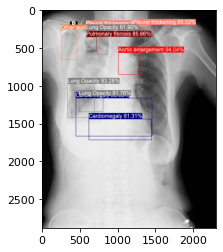

In [41]:
# test_path = '/home/kong/simple_detection_dogcat/tmp/cat_dog/images/test/'
# data_image = Image.open(test_path+'cat.3941.jpg')
# path_test = "/home/kong/14_disease_2022/tmp/data_ex7/images/test/124ec853c372fcf7f4428b26b32be62f.jpg"
path_test = f"/ramdisk/vinbigdata-chest-xray-png/train/7d0e636b3ef2ccbb0c67b3243a1478ce.png"
data_image = Image.open(path_test)
data_image = data_image.convert('RGB')
width, height = data_image.size
if width > 3800 or height > 3800:
    data_image.resize((int(width/3), int(height/3)))

elif width > 2500 or height > 2500:
    data_image.resize((int(width/2.5), int(height/2.5)))
    
img = preprocess_image(data_image)

pred = model(img, augment=opt.augment)[0]
print(pred)
pred = non_max_suppression(pred, opt.conf_thres, opt.iou_thres, classes=opt.classes, agnostic=opt.agnostic_nms)
print(pred)

img_result, result = draw_image(data_image, pred, names, img, colors)
print(result)
plt.imshow(img_result)
img_result.save("/home/kong/14_disease_2022/tmp/yolov5/runs/detect/exp/img_test.png") 


In [45]:
(pred)

[tensor([[1.00900e+03, 5.61000e+02, 1.28700e+03, 8.54000e+02, 9.40364e-01, 0.00000e+00],
         [4.47000e+02, 1.16200e+03, 1.45900e+03, 1.66800e+03, 9.33792e-01, 3.00000e+00],
         [3.38000e+02, 9.74000e+02, 6.95000e+02, 1.42300e+03, 9.32820e-01, 7.00000e+00],
         [5.81000e+02, 2.13000e+02, 9.42000e+02, 3.61000e+02, 9.26407e-01, 1.10000e+01],
         [4.89000e+02, 1.13600e+03, 8.11000e+02, 1.34600e+03, 9.17641e-01, 7.00000e+00],
         [2.51000e+02, 2.55000e+02, 4.65000e+02, 6.55000e+02, 9.15809e-01, 9.00000e+00],
         [5.86000e+02, 3.52000e+02, 7.20000e+02, 5.42000e+02, 8.56598e-01, 1.30000e+01],
         [1.20400e+03, 1.97000e+02, 1.43600e+03, 2.61000e+02, 8.55176e-01, 1.10000e+01],
         [5.86000e+02, 2.66000e+02, 8.75000e+02, 5.88000e+02, 8.19045e-01, 7.00000e+00],
         [6.19000e+02, 1.43800e+03, 1.45400e+03, 1.71800e+03, 8.13079e-01, 3.00000e+00]])]

In [32]:
result

[{'class_name': 'Aortic enlargement',
  'confidence': 94.036382,
  'position': {'xmin': 1009, 'ymin': 561, 'xmax': 1287, 'ymax': 854}},
 {'class_name': 'Cardiomegaly',
  'confidence': 93.379194,
  'position': {'xmin': 447, 'ymin': 1162, 'xmax': 1459, 'ymax': 1668}},
 {'class_name': 'Lung Opacity',
  'confidence': 93.281972,
  'position': {'xmin': 338, 'ymin': 974, 'xmax': 695, 'ymax': 1423}},
 {'class_name': 'Pleural thickening',
  'confidence': 92.64068,
  'position': {'xmin': 581, 'ymin': 213, 'xmax': 942, 'ymax': 361}},
 {'class_name': 'Lung Opacity',
  'confidence': 91.764081,
  'position': {'xmin': 489, 'ymin': 1136, 'xmax': 811, 'ymax': 1346}},
 {'class_name': 'Other lesion',
  'confidence': 91.580933,
  'position': {'xmin': 251, 'ymin': 255, 'xmax': 465, 'ymax': 655}},
 {'class_name': 'Pulmonary fibrosis',
  'confidence': 85.659766,
  'position': {'xmin': 586, 'ymin': 352, 'xmax': 720, 'ymax': 542}},
 {'class_name': 'Pleural thickening',
  'confidence': 85.517579,
  'position': 

In [10]:
dict_class={'Aortic enlargement': 0,
 'Atelectasis': 1,
 'Calcification': 2,
 'Cardiomegaly': 3,
 'Consolidation': 4,
 'ILD': 5,
 'Infiltration': 6,
 'Lung Opacity': 7,
 'Nodule/Mass': 8,
 'Other lesion': 9,
 'Pleural effusion': 10,
 'Pleural thickening': 11,
 'Pneumothorax': 12,
 'Pulmonary fibrosis': 13}

In [11]:
path_label = "/home/kong/14_disease_2022/tmp/data_ex7/labels/test/124ec853c372fcf7f4428b26b32be62f.txt"
f = open(path_label, "r")
print(f.read())

10 0.21723090277777776 0.4501736111111111 0.3728298611111111 0.5003472222222223
10 0.23003472222222224 0.46649305555555554 0.4045138888888889 0.5621527777777777
10 0.2482638888888889 0.45138888888888884 0.3168402777777778 0.43888888888888883


In [12]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm import tqdm

In [13]:
class_name = ['Aortic enlargement',
 'Atelectasis',
 'Calcification',
 'Cardiomegaly',
 'Consolidation',
 'ILD',
 'Infiltration',
 'Lung Opacity',
 'Nodule/Mass',
 'Other lesion',
 'Pleural effusion',
 'Pleural thickening',
 'Pneumothorax',
 'Pulmonary fibrosis']

In [14]:
col_name = ['name','Aortic enlargement',
 'Atelectasis',
 'Calcification',
 'Cardiomegaly',
 'Consolidation',
 'ILD',
 'Infiltration',
 'Lung Opacity',
 'Nodule/Mass',
 'Other lesion',
 'Pleural effusion',
 'Pleural thickening',
 'Pneumothorax',
 'Pulmonary fibrosis']

In [15]:
df = pd.DataFrame(columns = ['name','class'])
dir_img = os.listdir("/home/kong/14_disease_2022/tmp/data_ex7/images/test/")
path_label = "/home/kong/14_disease_2022/tmp/data_ex7/labels/test//"

name_ = []
class_ = []

for i in range(len(dir_img)):
    f = open(path_label+dir_img[i].split('.jpg')[0]+'.txt', "r")
    num_class = f.read()
    e = list(set([i.split()[0] for i in num_class.splitlines()]))
    e = [int(i) for i in e]
    name_.append(dir_img[i].split('.jpg')[0])
    class_.append(e)
df['name'] = name_
df['class'] = class_
df

,name,class
0,d0043062cebce85f2487407bc033d405_VerticalFlip,"[3, 0, 1, 13, 11, 4, 10, 7, 9]"
1,ddc38d560476be1d8fc06f8867c0277b,"[3, 11, 0]"
2,fbadbb00720fcc1385e05adaca2502e1_VerticalFlip,[0]
3,2e7b51cf120ec59d369331d09bba34b8,"[0, 13, 11, 10, 8, 7, 9]"
4,57415c4992802274b5a54930019c30f1_VerticalFlip,"[3, 6, 0, 13, 7, 9]"
...,...,...
1754,d754c0b8f318f683355ec2b11954abb4_VerticalFlip,"[0, 13, 11, 4, 10, 7, 9]"
1755,f32ab457c492c30221d3a89fe7c6b25a,"[0, 8, 5]"
1756,ff924bcbd38f123aec723aa7040d7e43_HorizontalFlip,"[1, 13, 11, 4, 10, 7]"
1757,98d31d7df7863752c8f85cd0be34ecc5_VerticalFlip,"[3, 0]"


In [16]:
mlb = MultiLabelBinarizer()
df = pd.DataFrame(mlb.fit_transform(df['class']),columns=class_name)
df['name'] = name_
df=df.reindex(columns=col_name)
df

,name,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,...,Other lesion,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis
0,d0043062cebce85f2487407bc033d405_VerticalFlip,1,1,0,1,...,1,1,1,0,1
1,ddc38d560476be1d8fc06f8867c0277b,1,0,0,1,...,0,0,1,0,0
2,fbadbb00720fcc1385e05adaca2502e1_VerticalFlip,1,0,0,0,...,0,0,0,0,0
3,2e7b51cf120ec59d369331d09bba34b8,1,0,0,0,...,1,1,1,0,1
4,57415c4992802274b5a54930019c30f1_VerticalFlip,1,0,0,1,...,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
1754,d754c0b8f318f683355ec2b11954abb4_VerticalFlip,1,0,0,0,...,1,1,1,0,1
1755,f32ab457c492c30221d3a89fe7c6b25a,1,0,0,0,...,0,0,0,0,0
1756,ff924bcbd38f123aec723aa7040d7e43_HorizontalFlip,0,1,0,0,...,0,1,1,0,1
1757,98d31d7df7863752c8f85cd0be34ecc5_VerticalFlip,1,0,0,1,...,0,0,0,0,0


In [17]:
for i in range(len(class_name)):
    e = df[class_name[i]]
    print(f"{class_name[i]} : {e.sum()}")

Aortic enlargement : 1261
Atelectasis : 74
Calcification : 191
Cardiomegaly : 918
Consolidation : 137
ILD : 159
Infiltration : 241
Lung Opacity : 509
Nodule/Mass : 340
Other lesion : 433
Pleural effusion : 409
Pleural thickening : 784
Pneumothorax : 38
Pulmonary fibrosis : 645


In [18]:
df_pred = pd.DataFrame(columns = ['name','class'])
name_ = []
class_ = []
for i in tqdm(range(len(df))):
    path_test = "/home/kong/14_disease_2022/tmp/data_ex7/images/test//"
    data_image = Image.open(path_test+df['name'][i]+".jpg")
    data_image = data_image.convert('RGB')
    width, height = data_image.size
    if width > 3800 or height > 3800:
        data_image.resize((int(width/3), int(height/3)))

    elif width > 2500 or height > 2500:
        data_image.resize((int(width/2.5), int(height/2.5)))

    img = preprocess_image(data_image)

    pred = model(img, augment=opt.augment)[0]
    pred = non_max_suppression(pred, opt.conf_thres, opt.iou_thres, classes=opt.classes, agnostic=opt.agnostic_nms)

    img_result, result = draw_image(data_image, pred, names, img, colors)
    result_class = list(set([result[i]['class_name'] for i in range(len(result))]))
    result_class = [dict_class[i] for i in result_class]

    name_.append(dir_img[i].split('.jpg')[0])
    class_.append(result_class)

    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1759/1759 [26:13<00:00,  1.12it/s]


In [19]:
df_pred['name'] = name_
df_pred['class'] = class_

In [20]:
df_pred

,name,class
0,d0043062cebce85f2487407bc033d405_VerticalFlip,"[13, 11, 7, 3, 1, 0, 9]"
1,ddc38d560476be1d8fc06f8867c0277b,"[3, 0, 11]"
2,fbadbb00720fcc1385e05adaca2502e1_VerticalFlip,[0]
3,2e7b51cf120ec59d369331d09bba34b8,"[13, 11, 7, 0, 10]"
4,57415c4992802274b5a54930019c30f1_VerticalFlip,"[7, 6, 3, 0, 9]"
...,...,...
1754,d754c0b8f318f683355ec2b11954abb4_VerticalFlip,"[13, 11, 7, 4, 10, 0, 9]"
1755,f32ab457c492c30221d3a89fe7c6b25a,[0]
1756,ff924bcbd38f123aec723aa7040d7e43_HorizontalFlip,"[13, 11, 7, 4, 1, 10]"
1757,98d31d7df7863752c8f85cd0be34ecc5_VerticalFlip,"[3, 0]"


In [21]:
mlb = MultiLabelBinarizer()
bb = pd.DataFrame(mlb.fit_transform(df_pred['class']),columns=class_name)
bb['name'] = name_
bb=bb.reindex(columns=col_name)
# df_pred

In [22]:
bb

,name,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,...,Other lesion,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis
0,d0043062cebce85f2487407bc033d405_VerticalFlip,1,1,0,1,...,1,0,1,0,1
1,ddc38d560476be1d8fc06f8867c0277b,1,0,0,1,...,0,0,1,0,0
2,fbadbb00720fcc1385e05adaca2502e1_VerticalFlip,1,0,0,0,...,0,0,0,0,0
3,2e7b51cf120ec59d369331d09bba34b8,1,0,0,0,...,0,1,1,0,1
4,57415c4992802274b5a54930019c30f1_VerticalFlip,1,0,0,1,...,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1754,d754c0b8f318f683355ec2b11954abb4_VerticalFlip,1,0,0,0,...,1,1,1,0,1
1755,f32ab457c492c30221d3a89fe7c6b25a,1,0,0,0,...,0,0,0,0,0
1756,ff924bcbd38f123aec723aa7040d7e43_HorizontalFlip,0,1,0,0,...,0,1,1,0,1
1757,98d31d7df7863752c8f85cd0be34ecc5_VerticalFlip,1,0,0,1,...,0,0,0,0,0


In [23]:
df

,name,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,...,Other lesion,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis
0,d0043062cebce85f2487407bc033d405_VerticalFlip,1,1,0,1,...,1,1,1,0,1
1,ddc38d560476be1d8fc06f8867c0277b,1,0,0,1,...,0,0,1,0,0
2,fbadbb00720fcc1385e05adaca2502e1_VerticalFlip,1,0,0,0,...,0,0,0,0,0
3,2e7b51cf120ec59d369331d09bba34b8,1,0,0,0,...,1,1,1,0,1
4,57415c4992802274b5a54930019c30f1_VerticalFlip,1,0,0,1,...,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
1754,d754c0b8f318f683355ec2b11954abb4_VerticalFlip,1,0,0,0,...,1,1,1,0,1
1755,f32ab457c492c30221d3a89fe7c6b25a,1,0,0,0,...,0,0,0,0,0
1756,ff924bcbd38f123aec723aa7040d7e43_HorizontalFlip,0,1,0,0,...,0,1,1,0,1
1757,98d31d7df7863752c8f85cd0be34ecc5_VerticalFlip,1,0,0,1,...,0,0,0,0,0


In [24]:
for i in range(len(class_name)):
    e = df[class_name[i]]
    print(f"{class_name[i]} : {e.sum()}")

Aortic enlargement : 1261
Atelectasis : 74
Calcification : 191
Cardiomegaly : 918
Consolidation : 137
ILD : 159
Infiltration : 241
Lung Opacity : 509
Nodule/Mass : 340
Other lesion : 433
Pleural effusion : 409
Pleural thickening : 784
Pneumothorax : 38
Pulmonary fibrosis : 645


In [25]:
for i in range(len(class_name)):
    e = bb[class_name[i]]
    print(f"{class_name[i]} : {e.sum()}")

Aortic enlargement : 1263
Atelectasis : 57
Calcification : 159
Cardiomegaly : 922
Consolidation : 90
ILD : 149
Infiltration : 185
Lung Opacity : 400
Nodule/Mass : 306
Other lesion : 367
Pleural effusion : 357
Pleural thickening : 735
Pneumothorax : 31
Pulmonary fibrosis : 592


In [26]:
y_pred = bb[bb.columns[1:15]]
y_test = df[df.columns[1:15]]

y_test = np.array(y_test)
y_pred = np.array(y_pred)

In [27]:
y_test

array([[1, 1, 0, ..., 1, 0, 1],
       [1, 0, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 1, 0, 1],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [28]:
y_pred

array([[1, 1, 0, ..., 1, 0, 1],
       [1, 0, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 1, 0, 1],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 1, 0, 0]])

In [29]:
cm = [None for i in range(len(class_name))]
for n in range(len(class_name)):
    tp,fp,tn,fn = 0,0,0,0
    count_negative = 0
    for i in range(len(y_pred)):
            if y_pred[i][n]== 1 and y_pred[i][n] == y_test[i][n]:
                tp +=1
            elif y_pred[i][n]== 0 and y_pred[i][n] == y_test[i][n]:
#                 if count_negative < number_class[n]:
                    tn +=1
                    count_negative +=1
#                 else:
#                     continue

            elif y_pred[i][n]== 1 and y_pred[i][n] != y_test[i][n]:
#                 if count_negative < number_class[n]:
                    fp +=1
                    count_negative +=1
#                 else:
#                     continue
            elif y_pred[i][n]== 0 and y_pred[i][n] != y_test[i][n]:
                fn +=1
    cm[n] = np.array([[tp,fp],[fn,tn]])
    print(cm[n])

[[1257    6]
 [   4  492]]
[[  56    1]
 [  18 1684]]
[[ 159    0]
 [  32 1568]]
[[916   6]
 [  2 835]]
[[  90    0]
 [  47 1622]]
[[ 149    0]
 [  10 1600]]
[[ 185    0]
 [  56 1518]]
[[ 398    2]
 [ 111 1248]]
[[ 303    3]
 [  37 1416]]
[[ 367    0]
 [  66 1326]]
[[ 357    0]
 [  52 1350]]
[[732   3]
 [ 52 972]]
[[  31    0]
 [   7 1721]]
[[ 590    2]
 [  55 1112]]


In [30]:
results=np.array(class_name)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred,target_names=class_name))

                    precision    recall  f1-score   support

Aortic enlargement       1.00      1.00      1.00      1261
       Atelectasis       0.98      0.76      0.85        74
     Calcification       1.00      0.83      0.91       191
      Cardiomegaly       0.99      1.00      1.00       918
     Consolidation       1.00      0.66      0.79       137
               ILD       1.00      0.94      0.97       159
      Infiltration       1.00      0.77      0.87       241
      Lung Opacity       0.99      0.78      0.88       509
       Nodule/Mass       0.99      0.89      0.94       340
      Other lesion       1.00      0.85      0.92       433
  Pleural effusion       1.00      0.87      0.93       409
Pleural thickening       1.00      0.93      0.96       784
      Pneumothorax       1.00      0.82      0.90        38
Pulmonary fibrosis       1.00      0.91      0.95       645

         micro avg       1.00      0.91      0.95      6139
         macro avg       1.00      0.8

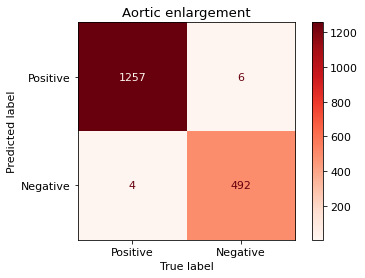

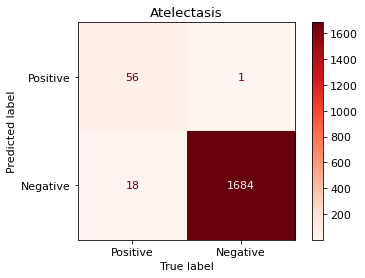

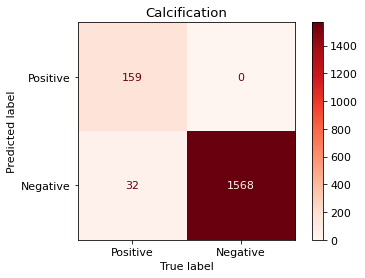

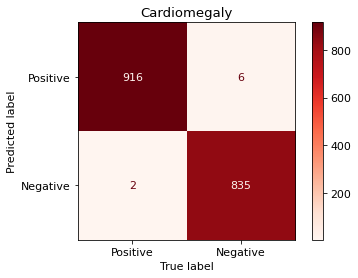

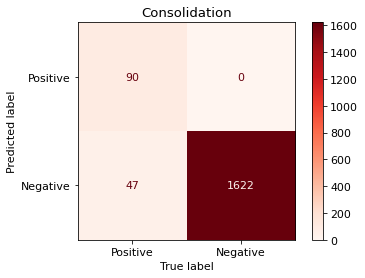

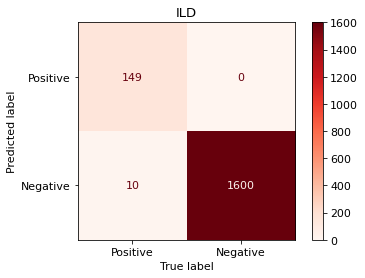

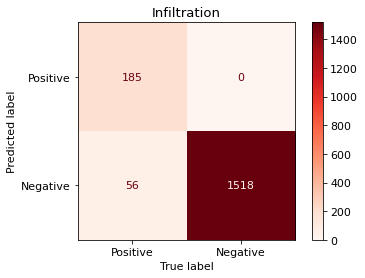

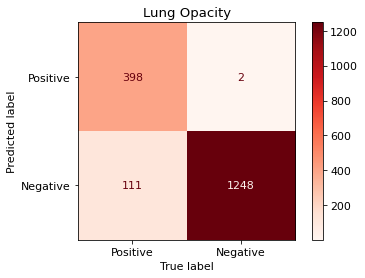

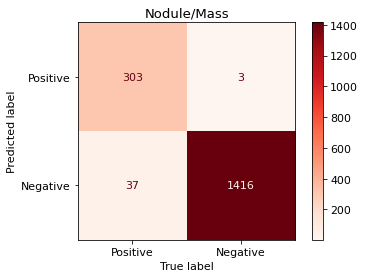

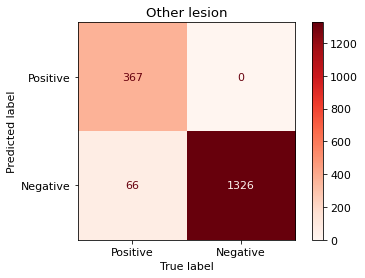

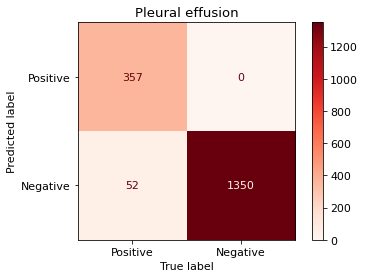

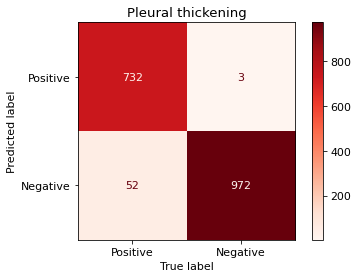

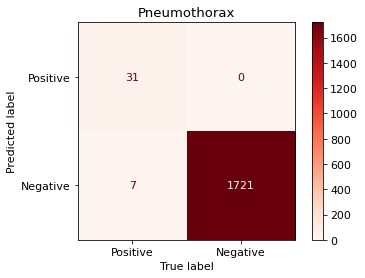

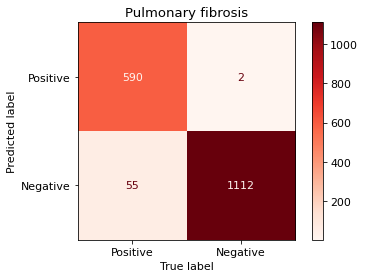

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
for n in range(len(class_name)):
    cmd = ConfusionMatrixDisplay(cm[n],display_labels=['Positive','Negative'])
    cmd.plot(cmap='Reds')
    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    plt.title(class_name[n])

In [32]:
import pandas as pd
df = pd.DataFrame(columns=['class','TP','FP','FN','TN','Accuracy','Sensitivity','Specificity','F1_Score'])
df['class'] = class_name
accuracy = []
sensitivity = []
specificity = []
precision = []
f1_Score = []
tp = []
fp = []
tn = []
fn = []
for n in range(len(cm)):
    TP = cm[n][0][0]
    FP = cm[n][0][1]
    FN = cm[n][1][0]
    TN = cm[n][1][1]

    Accuracy = (TP + TN) / (TP + FP + TN + FN)
    Sensitivity = TP / (TP + FN)
    Specificity = TN / (TN + FP)
    Precision = TP / (TP + FP)
    F1_Score = (2 * Precision * Sensitivity) / (Precision + Sensitivity)

    tp.append(f'{TP}')
    fp.append(f'{FP}')
    fn.append(f'{FN}')
    tn.append(f'{TN}')
    accuracy.append(f'{Accuracy:.2f}')
    sensitivity.append(f'{Sensitivity:.2f}')
    specificity.append(f'{Specificity:.2f}')
    precision.append(f'{Precision:.2f}')
    f1_Score.append(f'{F1_Score:.2f}')


    print(f"Accuracy : {Accuracy:.2f}")
    print(f"Sensitivity : {Sensitivity:.2f}")
    print(f"Specificity : {Specificity:.2f}")
    print(f"Precision : {Precision:.2f}")
    print(f"F1_Score : {F1_Score:.2f}")
    print("----------------")

df['TP'] =tp
df['FP'] =fp
df['FN'] =fn
df['TN'] =tn
df['Accuracy'] = accuracy
df['Sensitivity'] = sensitivity
df['Specificity'] = specificity
df['Precision'] = precision
df['F1_Score'] = f1_Score

print(df)
df.to_csv('/home/kong/14_disease_2022/exp/ex7/Accuracy_test.csv')

Accuracy : 0.99
Sensitivity : 1.00
Specificity : 0.99
Precision : 1.00
F1_Score : 1.00
----------------
Accuracy : 0.99
Sensitivity : 0.76
Specificity : 1.00
Precision : 0.98
F1_Score : 0.85
----------------
Accuracy : 0.98
Sensitivity : 0.83
Specificity : 1.00
Precision : 1.00
F1_Score : 0.91
----------------
Accuracy : 1.00
Sensitivity : 1.00
Specificity : 0.99
Precision : 0.99
F1_Score : 1.00
----------------
Accuracy : 0.97
Sensitivity : 0.66
Specificity : 1.00
Precision : 1.00
F1_Score : 0.79
----------------
Accuracy : 0.99
Sensitivity : 0.94
Specificity : 1.00
Precision : 1.00
F1_Score : 0.97
----------------
Accuracy : 0.97
Sensitivity : 0.77
Specificity : 1.00
Precision : 1.00
F1_Score : 0.87
----------------
Accuracy : 0.94
Sensitivity : 0.78
Specificity : 1.00
Precision : 0.99
F1_Score : 0.88
----------------
Accuracy : 0.98
Sensitivity : 0.89
Specificity : 1.00
Precision : 0.99
F1_Score : 0.94
----------------
Accuracy : 0.96
Sensitivity : 0.85
Specificity : 1.00
Precision 

In [33]:
dir_img = os.listdir("/home/kong/14_disease_2022/dataset/CXR_test/")

In [44]:
len(dir_img)

20

In [35]:
dir_img[0]

'1 (5).png'

tensor([[[6.44640e+00, 5.22901e+00, 1.36087e+01,  ..., 1.58867e-01, 1.97750e-02, 6.10770e-02],
         [1.24466e+01, 4.64500e+00, 2.00105e+01,  ..., 1.19224e-01, 2.03515e-02, 5.08323e-02],
         [2.11588e+01, 4.75816e+00, 3.00446e+01,  ..., 4.26630e-02, 1.66658e-02, 1.65446e-01],
         ...,
         [5.54614e+02, 6.13896e+02, 2.18925e+02,  ..., 8.46780e-02, 5.79401e-02, 6.94007e-03],
         [5.91081e+02, 6.15540e+02, 1.65886e+02,  ..., 2.28345e-01, 1.11469e-01, 7.29971e-03],
         [6.16123e+02, 6.14803e+02, 1.20314e+02,  ..., 1.41545e-01, 1.13216e-01, 8.11304e-03]]])
[tensor([], size=(0, 6))]
[]
tensor([[[7.30290e+00, 6.02597e+00, 1.56787e+01,  ..., 1.85894e-01, 1.87623e-02, 5.01054e-02],
         [1.20466e+01, 5.43914e+00, 1.92086e+01,  ..., 1.38526e-01, 1.99400e-02, 5.27504e-02],
         [1.72976e+01, 4.59898e+00, 2.31802e+01,  ..., 6.69043e-02, 1.66359e-02, 2.41896e-01],
         ...,
         [5.56705e+02, 6.08064e+02, 2.03075e+02,  ..., 1.98942e-01, 1.88701e-01, 1.622

tensor([[[7.30290e+00, 6.02597e+00, 1.56787e+01,  ..., 1.85894e-01, 1.87623e-02, 5.01054e-02],
         [1.20466e+01, 5.43914e+00, 1.92086e+01,  ..., 1.38526e-01, 1.99400e-02, 5.27504e-02],
         [1.72976e+01, 4.59898e+00, 2.31802e+01,  ..., 6.69043e-02, 1.66359e-02, 2.41896e-01],
         ...,
         [5.56705e+02, 6.08064e+02, 2.03075e+02,  ..., 1.98942e-01, 1.88701e-01, 1.62217e-02],
         [5.85077e+02, 6.11747e+02, 1.46387e+02,  ..., 1.72156e-01, 1.98005e-01, 3.53023e-02],
         [6.10423e+02, 6.18908e+02, 1.23125e+02,  ..., 7.73337e-02, 1.11001e-01, 7.37386e-02]]])
[tensor([], size=(0, 6))]
[]
tensor([[[6.44640e+00, 5.22901e+00, 1.36087e+01,  ..., 1.58867e-01, 1.97750e-02, 6.10770e-02],
         [1.24466e+01, 4.64500e+00, 2.00105e+01,  ..., 1.19224e-01, 2.03515e-02, 5.08323e-02],
         [2.11588e+01, 4.75816e+00, 3.00446e+01,  ..., 4.26630e-02, 1.66658e-02, 1.65446e-01],
         ...,
         [5.54614e+02, 6.13896e+02, 2.18925e+02,  ..., 8.46780e-02, 5.79401e-02, 6.940

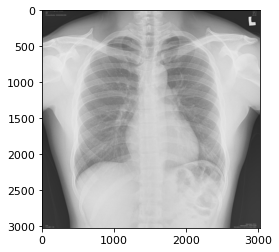

In [43]:
for i in range(len(dir_img)):
    path_test = "/home/kong/14_disease_2022/dataset/CXR_test/"+dir_img[i]
    data_image = Image.open(path_test)
    data_image = data_image.convert('RGB')
    width, height = data_image.size
    if width > 3800 or height > 3800:
        data_image.resize((int(width/3), int(height/3)))

    elif width > 2500 or height > 2500:
        data_image.resize((int(width/2.5), int(height/2.5)))

    img = preprocess_image(data_image)

    pred = model(img, augment=opt.augment)[0]
    print(pred)
    pred = non_max_suppression(pred, opt.conf_thres, opt.iou_thres, classes=opt.classes, agnostic=opt.agnostic_nms)
    print(pred)

    img_result, result = draw_image(data_image, pred, names, img, colors)
    print(result)
    plt.imshow(img_result)
    img_result.save(f"/home/kong/14_disease_2022/dataset/CXR_pred/{dir_img[i]}")
    
